In [2]:
# Standard libraries
import os

# Numerical and data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image as tf_image
from tensorflow.keras import models as tf_models
from tensorflow.keras import layers as tf_layers
from tensorflow.keras import optimizers as tf_optimizers

# Scikit-learn
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler, LabelBinarizer

In [3]:
# Load and preprocess data from Excel files
def load_and_preprocess_image(base_dir, path, target_size):
    img_path = os.path.join(base_dir, path.replace('\\', '/'))
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Use EfficientNetV2M-specific preprocessing
    preprocessed_img = tf.keras.applications.efficientnet_v2.preprocess_input(img_array)
    return preprocessed_img


def get_data_for_training(excel_path, base_dir, image_size=(64, 64)):
    df = pd.read_excel(excel_path)
    df = df.dropna(subset=['image_path'])
    class_names = df.columns[2:]  # Assuming class columns start from the 3rd column
    X = np.array([load_and_preprocess_image(base_dir, path, image_size) for path in df['image_path'].values])
    y = df[class_names].values
    return X, y, df['image_path'].values

training_dir = "/kaggle/input/dataset/Dataset/training"
validation_dir = "/kaggle/input/dataset/Dataset/validation"

train_excel_path = "/kaggle/input/dataset/Dataset/training/training_data.xlsx"
val_excel_path = "/kaggle/input/dataset/Dataset/validation/validation_data.xlsx"
base_dir = "/kaggle/input/dataset/Dataset"

# Load the training and validation data
X_train, y_train, _ = get_data_for_training(train_excel_path, base_dir, image_size=(64, 64))
X_val, y_val, image_paths = get_data_for_training(val_excel_path, base_dir, image_size=(64, 64))

In [5]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_train: {X_val.shape}, y_train: {y_val.shape}")

X_train: (37607, 64, 64, 3), y_train: (37607, 10)
X_train: (16132, 64, 64, 3), y_train: (16132, 10)


In [6]:
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 32
NUM_EPOCHS = 50
IMAGE_SIZE = 64
INPUT_SHAPE = (64, 64, 3)

In [7]:
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
y_train_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

In [8]:
print(class_weights)
print(class_weights_dict)

[ 3.25883882  4.50923261  1.39595397  5.44240232  4.74835859  4.72449749
  0.13120399  3.23640275  5.67224736 23.80189873]
{0: 3.258838821490468, 1: 4.509232613908873, 2: 1.3959539717891611, 3: 5.442402315484805, 4: 4.748358585858586, 5: 4.724497487437186, 6: 0.1312039912081778, 7: 3.236402753872633, 8: 5.672247360482655, 9: 23.801898734177215}


In [ ]:
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras import layers, callbacks, optimizers, losses, metrics
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Define input shape and number of classes
INPUT_SHAPE = (64, 64, 3)
NUM_CLASSES = 10  

# Define the EfficientNetV2M model configuration
def create_efficientnetv2m_classifier(input_shape, num_classes):
    efficientnet_base = EfficientNetV2M(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling='avg'
    )

    model = tf.keras.models.Sequential([
        layers.Input(shape=input_shape),
        efficientnet_base,
        layers.Dropout(0.3),
        layers.Dense(1024, activation="gelu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(512, activation="gelu"),
        layers.Dense(num_classes, activation="softmax")
    ], name='EfficientNetV2M_Classifier')

    return model

# Instantiate the EfficientNetV2M model
with tf.device('/gpu:0'):
    model = create_efficientnetv2m_classifier(INPUT_SHAPE, NUM_CLASSES)

    # Callbacks
    lr_callback = callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    )

    es_transfer = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True
    )

    es_partial_fine_tune = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    es_full_fine_tune = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=13,
        restore_best_weights=True
    )

    checkpoint_filepath = '/kaggle/working/CheckPoints/EfficientNetV2M/model_best.weights.h5'
    chk_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=False,
        save_weights_only=True,
        mode='auto',
        verbose=1
    )



In [10]:
# Print the name and type of the second layer in the model
print(f"Layer 1 Name: {model.layers[0].name}")
print(f"Layer 1 Type: {type(model.layers[1])}")

Layer 1 Name: efficientnetv2-m
Layer 1 Type: <class 'keras.src.layers.regularization.dropout.Dropout'>


In [12]:

# First Phase: Training with Frozen Base Model
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
with tf.device('/gpu:0'):
    model.layers[0].trainable = False  # Freeze EfficientNet base
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=losses.CategoricalCrossentropy(),
        metrics=[metrics.CategoricalAccuracy(name='accuracy')]
    )
    print("Phase 1: Training with Frozen Base Model")
    history_phase1 = model.fit(
        x=X_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=25,
        validation_data=(X_val, y_val),
        callbacks=[lr_callback, es_transfer, chk_callback]
    )

# Reload Model for Fine-Tuning
# model.load_weights(checkpoint_filepath)
# print("Loaded model weights from checkpoint.")


Phase 1: Training with Frozen Base Model
Epoch 1/25


I0000 00:00:1732149338.439520    1854 service.cc:145] XLA service 0x7ede44003ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732149338.439582    1854 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   1/1176 ━━━━━━━━━━━━━━━━━━━━ 46:18:06 142s/step - accuracy: 0.1250 - loss: 3.4048

I0000 00:00:1732149447.341076    1854 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7561 - loss: 1.3888
Epoch 1: saving model to /kaggle/working/CheckPoints/EfficientNetV2M/model_best.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 330s 160ms/step - accuracy: 0.7561 - loss: 1.3886 - val_accuracy: 0.7626 - val_loss: 0.9997 - learning_rate: 0.0010
Epoch 2/25
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7613 - loss: 0.9760
Epoch 2: saving model to /kaggle/working/CheckPoints/EfficientNetV2M/model_best.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 60s 51ms/step - accuracy: 0.7613 - loss: 0.9760 - val_accuracy: 0.7617 - val_loss: 0.8946 - learning_rate: 0.0010
Epoch 3/25
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7641 - loss: 0.9498
Epoch 3: saving model to /kaggle/working/CheckPoints/EfficientNetV2M/model_best.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.7641 - loss: 0.9498 - val_accuracy: 0.7627 - val_loss: 0.8990 - learning_rate: 0.0010
Epoch 4/25
1176/1176 ━━━━━━━━━━━━

In [13]:
# Step 2: Partial Fine-Tuning (Unfreeze Top ~30% Layers)
LEARNING_RATE = 1e-4
with tf.device('/gpu:0'):
    efficientnet_base = model.layers[0]  # EfficientNetV2M base
    for layer in efficientnet_base.layers[-60:]:
        layer.trainable = True
    for layer in efficientnet_base.layers[:-60]:
        layer.trainable = False

    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=losses.CategoricalCrossentropy(),
        metrics=[metrics.CategoricalAccuracy(name='accuracy')]
    )

    print("Step 2: Partial Fine-Tuning with Top Layers Unfrozen")
    history_partial_finetune = model.fit(
        x=X_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=25,
        validation_data=(X_val, y_val),
        callbacks=[lr_callback, es_partial_fine_tune, chk_callback]
    )

Step 2: Partial Fine-Tuning with Top Layers Unfrozen
Epoch 1/25
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7763 - loss: 0.7609
Epoch 1: saving model to /kaggle/working/CheckPoints/EfficientNetV2M/model_best.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 391s 188ms/step - accuracy: 0.7763 - loss: 0.7609 - val_accuracy: 0.8219 - val_loss: 0.5937 - learning_rate: 1.0000e-04
Epoch 2/25
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8151 - loss: 0.6143
Epoch 2: saving model to /kaggle/working/CheckPoints/EfficientNetV2M/model_best.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - accuracy: 0.8151 - loss: 0.6143 - val_accuracy: 0.8306 - val_loss: 0.5392 - learning_rate: 1.0000e-04
Epoch 3/25
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8249 - loss: 0.5605
Epoch 3: saving model to /kaggle/working/CheckPoints/EfficientNetV2M/model_best.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 81s 69ms/step - accuracy: 0.8249 - loss: 0.5605 - val_accuracy: 0.8410 - va

In [15]:
# Step 3: Full Fine-Tuning (Unfreeze Entire Model)
LEARNING_RATE = 5e-6
with tf.device('/gpu:0'):
    model.layers[0].trainable = True  # Unfreeze entire base model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=losses.CategoricalCrossentropy(),
        metrics=[metrics.CategoricalAccuracy(name='accuracy')]
    )

    print("Phase 3: Fine-Tuning with Entire Model Unfrozen")
    history_phase3 = model.fit(
        x=X_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(X_val, y_val),
        callbacks=[lr_callback, es_full_fine_tune, chk_callback]
    )




Phase 3: Fine-Tuning with Entire Model Unfrozen
Epoch 1/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9064 - loss: 0.2755
Epoch 1: saving model to /kaggle/working/CheckPoints/EfficientNetV2M/model_best.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 939s 411ms/step - accuracy: 0.9064 - loss: 0.2755 - val_accuracy: 0.8761 - val_loss: 0.4045 - learning_rate: 5.0000e-06
Epoch 2/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9158 - loss: 0.2539
Epoch 2: saving model to /kaggle/working/CheckPoints/EfficientNetV2M/model_best.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 166s 141ms/step - accuracy: 0.9158 - loss: 0.2539 - val_accuracy: 0.8790 - val_loss: 0.4059 - learning_rate: 5.0000e-06
Epoch 3/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9196 - loss: 0.2417
Epoch 3: saving model to /kaggle/working/CheckPoints/EfficientNetV2M/model_best.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 166s 141ms/step - accuracy: 0.9196 - loss: 0.2417 - val_accuracy: 0.8815 - v

In [ ]:
# Predict on the validation set
y_pred = model.predict(X_val, batch_size=32, verbose=1)  # Use the new EfficientNetV2M model
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Save validation predictions to an Excel file
results_df = pd.DataFrame({
    'Image_path': image_paths,  
    'actual_class': y_val_classes,
    'predicted_class': y_pred_classes
})

results_file_path = os.path.join('/kaggle/working', "results_efficientnetv2m.xlsx")
# Save the file
results_df.to_excel(results_file_path, index=False, sheet_name='Sheet1')

print(f"Results saved to: {results_file_path}")


505/505 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step
Results saved to: /kaggle/working/results_efficientnetv2m.xlsx


In [18]:
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_val_classes, y_pred_classes, normalize='true')
print(cm)

Confusion Matrix:
[[6.47887324e-01 1.81086519e-02 1.34808853e-01 1.60965795e-02
  4.02414487e-03 1.40845070e-02 1.26760563e-01 3.62173038e-02
  2.01207243e-03 0.00000000e+00]
 [8.35654596e-03 7.71587744e-01 1.08635097e-01 1.67130919e-02
  0.00000000e+00 8.35654596e-03 6.12813370e-02 1.94986072e-02
  5.57103064e-03 0.00000000e+00]
 [6.66666667e-02 3.37662338e-02 5.66233766e-01 6.49350649e-02
  2.16450216e-02 2.16450216e-02 1.87878788e-01 3.11688312e-02
  4.32900433e-03 1.73160173e-03]
 [2.35690236e-02 4.04040404e-02 2.42424242e-01 4.54545455e-01
  2.35690236e-02 6.73400673e-03 1.34680135e-01 7.40740741e-02
  0.00000000e+00 0.00000000e+00]
 [5.88235294e-03 2.94117647e-03 5.58823529e-02 1.17647059e-02
  7.73529412e-01 2.35294118e-02 1.00000000e-01 2.35294118e-02
  2.94117647e-03 0.00000000e+00]
 [2.04081633e-02 1.16618076e-02 4.37317784e-02 5.83090379e-03
  2.04081633e-02 7.25947522e-01 1.37026239e-01 3.20699708e-02
  2.91545190e-03 0.00000000e+00]
 [3.74379425e-03 1.79051030e-03 1.294050

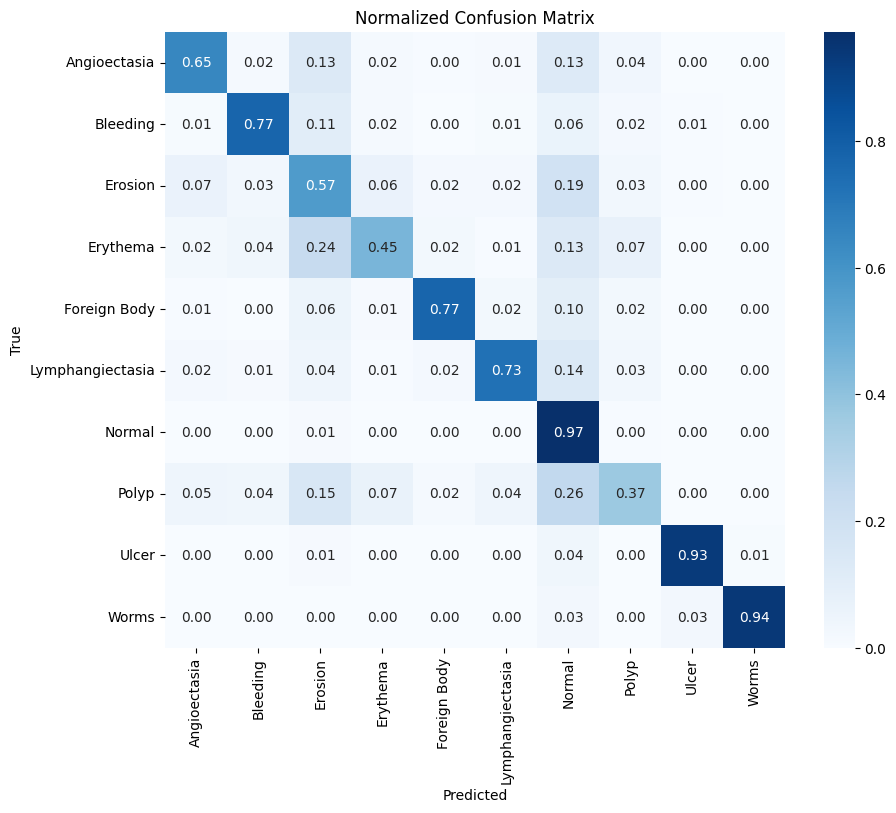

In [19]:
# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


In [20]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_val_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       497
           1       0.72      0.77      0.75       359
           2       0.59      0.57      0.58      1155
           3       0.48      0.45      0.47       297
           4       0.79      0.77      0.78       340
           5       0.72      0.73      0.72       343
           6       0.95      0.97      0.96     12287
           7       0.55      0.37      0.44       500
           8       0.95      0.93      0.94       286
           9       0.91      0.94      0.93        68

    accuracy                           0.89     16132
   macro avg       0.73      0.72      0.72     16132
weighted avg       0.88      0.89      0.89     16132



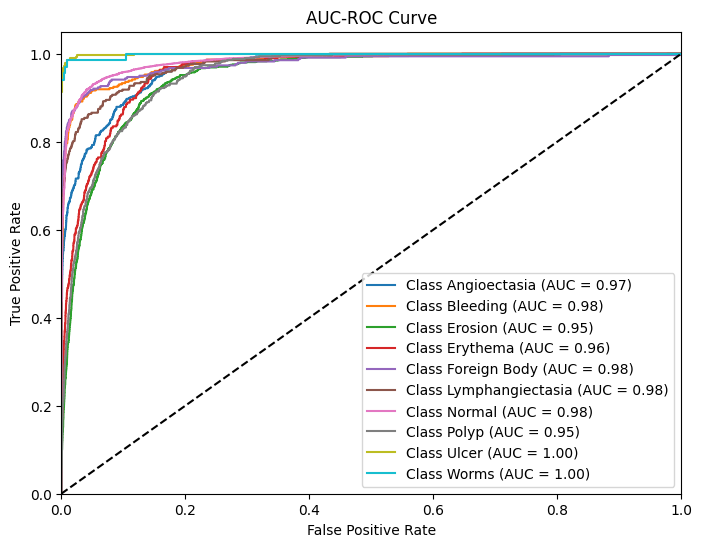

In [23]:
# Plot AUC-ROC curve
lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_pred[:, i])

# Plot AUC-ROC for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()
